# Practical Implementation of a Deep Learning Object Detection Model

In this study, convolutional neural network architectures are used to identify bird species. I am using a dataset of 1500 total photos, 500 images for each of the three classes of bird species. TurdusMerula, ErithacusRubecula, and PeriparusAter are the names of these classes. An annotation tool was used to tag these pictures. The pictures and XML files were used to construct the TFRecords, which were then used to train the model. For training, I'll employ SSD ResNet50 and Faster R-CNN. A powerful, cutting-edge model with good performance and accuracy is faster R-CNN. However, due to its strength, it is slow to detect in real time and from videos. Additionally, I'll be training an SSD ResNet50, a quicker model with worse accuracy.

I'll compare the evaluation metrics for both models before deciding which one is the best for deployment and inference.

# Data Pre-Processing

In [1]:
# importing all necassary packages for preprocessing data
import os
import seaborn as sns
import numpy as np
from matplotlib.pyplot import imread
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import shutil
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Resolution distribution of images

lets see the resolution distribution of the image dataset to select the right model for training

In [2]:
dim1 = []
dim2 = []
for image_filename in os.listdir('./images'):
    name, ext = os.path.splitext(image_filename)
    try:
        if not ext == '.xml':
            img = imread('./images/'+image_filename)
            d1,d2,color = img.shape
            dim1.append(d1)
            dim2.append(d2)
    except:
        print(image_filename)
        continue

test
cleaned
train


/home/msc1/anaconda3/envs/Object-Detection-API/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


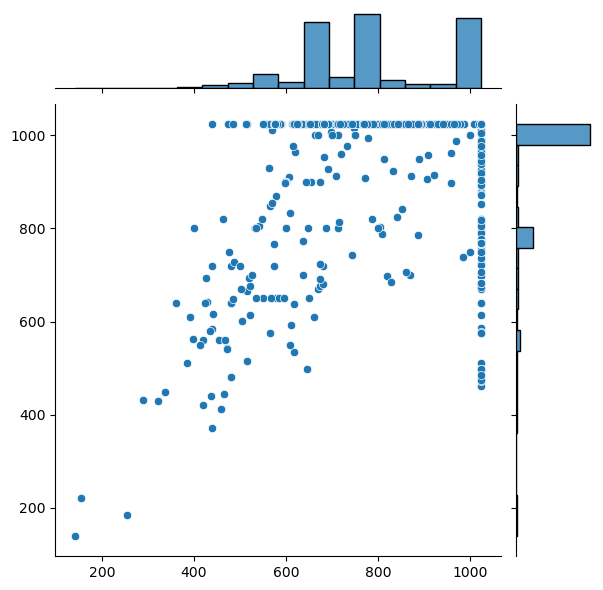

In [3]:
sns.jointplot(dim1,dim2)

As you can see, most photos have resolutions between 1000 and 2000 on the x and y axes. It would be preferable to select a model that has already received 1024 x 1024 image training. Models trained on a wide range of resolutions are available via the Tensorflow Object Detection API.

below we have the maximum, minimum and mean of the resolutions

In [4]:
np.mean(dim1)

790.9086666666667

In [5]:
print('Min:', np.min(dim1))
print('Max:', np.max(dim1))

Min: 142
Max: 1024


In [6]:
np.mean(dim2)

931.9793333333333

In [7]:
print('Min:', np.min(dim2))
print('Max:', np.max(dim2))

Min: 140
Max: 1024


# Removing Nogood images and XML files

There were many photographs that were tagged with data but either didn't contain the object or weren't very clear. The decision to label the pictures as NoGood was a wise one. However, it's crucial to remove those files before establishing TFRecords.

The code below generates a dataframe and pulls values from the XML file.

In [8]:
# function to extract values from xml files and creating a dataframe with those values
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
#         print(xml_file)
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     float(root.find('size')[0].text),
                     float(root.find('size')[1].text),
                     member[0].text,
                     float(member[4][0].text),
                     float(member[4][2].text),
                     float(member[4][1].text),
                     float(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

XML files are converted to dataframes, which are then analysed to identify filenames with NoGood values. This step is carried out to get rid of files with Nogood values in pictures and xml.

In [9]:
image_path = os.path.join(os.getcwd(), 'images/')
print(image_path)
xml_df = xml_to_csv(image_path)
xml_df.head()

/home/msc1/Desktop/Tensorflow-Object-Detection-API/Base/v1/object_detection/images/


,filename,width,height,class,xmin,ymin,xmax,ymax
0,Periparus_ater229.jpg,768.0,1024.0,Periparus_ater,369.179184,376.977687,425.057781,430.316348
1,ErthacusRubecula373.jpg,1024.0,893.0,Erithacus_Rubecula,337.439051,71.780917,897.180467,841.034482
2,ErthacusRubecula109.jpg,768.0,1024.0,Erithacus_Rubecula,339.467115,298.691342,421.759631,390.127471
3,ErthacusRubecula122.jpg,1024.0,683.0,Erithacus_Rubecula,429.441355,105.711110,966.128570,646.464138
4,ErthacusRubecula321.jpg,719.0,575.0,Erithacus_Rubecula,202.803818,165.015786,510.868724,509.323622


Check the unique values of column class

In [10]:
xml_df['class'].unique()

array(['Periparus_ater', 'Erithacus_Rubecula', 'Turdus_merula', 'Nogood'],
      dtype=object)

The code below shows all rows with Nogood values

In [11]:
xml_df.loc[xml_df['class'] == 'Nogood']

,filename,width,height,class,xmin,ymin,xmax,ymax
41,Periparus_ater67.jpg,1024.0,866.0,Nogood,659.925168,170.121194,688.278702,203.629916
98,Turdus_merula142.jpg,1024.0,768.0,Nogood,376.242277,359.202541,612.456346,519.218524
109,Turdus_merula29.jpg,1024.0,768.0,Nogood,443.285084,324.164035,559.659432,434.304044
115,Turdus_merula365.jpg,676.0,521.0,Nogood,142.458044,148.194587,467.076144,429.392431
127,Turdus_merula391.jpg,1024.0,516.0,Nogood,445.297521,109.912184,742.226824,365.885722
134,Turdus_merula109.jpg,768.0,1024.0,Nogood,290.701180,466.324245,467.477696,606.526309
139,Turdus_merula368.jpg,768.0,1024.0,Nogood,454.820586,356.290454,674.267295,587.928647
140,Turdus_merula197.jpg,1024.0,1024.0,Nogood,127.192935,364.305751,543.730515,746.978487
205,Turdus_merula383.jpg,852.0,1024.0,Nogood,326.139812,193.737336,634.990736,762.673248
220,Turdus_merula494.jpg,1024.0,988.0,Nogood,384.282850,602.547911,639.145184,873.094082


the process of compiling a list of filenames with Nogood values

In [12]:
# dataframe containing only NoGood values
no_good_df = xml_df.loc[xml_df['class'] == 'Nogood']
# creating a list of filenames
no_good_list = list(no_good_df['filename'])
no_good_list

['Periparus_ater67.jpg',
 'Turdus_merula142.jpg',
 'Turdus_merula29.jpg',
 'Turdus_merula365.jpg',
 'Turdus_merula391.jpg',
 'Turdus_merula109.jpg',
 'Turdus_merula368.jpg',
 'Turdus_merula197.jpg',
 'Turdus_merula383.jpg',
 'Turdus_merula494.jpg',
 'Turdus_merula40.jpg',
 'Turdus_merula41.jpg',
 'Turdus_merula235.jpg',
 'Turdus_merula129.jpg',
 'Turdus_merula200.jpg',
 'Turdus_merula467.jpg',
 'Turdus_merula14.jpg',
 'Periparus_ater170.jpg',
 'Turdus_merula426.jpg',
 'Turdus_merula1.jpg',
 'Periparus_ater490.jpg',
 'Periparus_ater56.jpg',
 'Turdus_merula80.jpg',
 'Turdus_merula207.jpg',
 'Periparus_ater6.jpg',
 'Turdus_merula26.jpg',
 'Turdus_merula185.jpg',
 'Turdus_merula319.jpg',
 'Turdus_merula422.jpg',
 'Turdus_merula139.jpg',
 'Turdus_merula196.jpg',
 'Turdus_merula4.jpg',
 'Turdus_merula192.jpg',
 'Turdus_merula332.jpg',
 'Periparus_ater51.jpg',
 'Turdus_merula151.jpg',
 'Turdus_merula433.jpg',
 'Turdus_merula123.jpg',
 'Turdus_merula115.jpg',
 'Turdus_merula156.jpg']

# Script to delete Nogood images and XML files

the below script the images and xml files are Nogood are deleted

In [17]:
# loop through the filename list
for file in no_good_list:
    # check if file exists
    if os.path.isfile(image_path + file):
        #print(image_path + file)
        #remove image and xml files
        os.remove(image_path + file)
        os.remove(image_path + file.replace('jpg', 'xml'))
    else:
        print(f"Error: {file} file not found")

Error: Periparus_ater67.jpg file not found
Error: Turdus_merula142.jpg file not found
Error: Turdus_merula29.jpg file not found
Error: Turdus_merula365.jpg file not found
Error: Turdus_merula391.jpg file not found
Error: Turdus_merula109.jpg file not found
Error: Turdus_merula368.jpg file not found
Error: Turdus_merula197.jpg file not found
Error: Turdus_merula383.jpg file not found
Error: Turdus_merula494.jpg file not found
Error: Turdus_merula40.jpg file not found
Error: Turdus_merula41.jpg file not found
Error: Turdus_merula235.jpg file not found
Error: Turdus_merula129.jpg file not found
Error: Turdus_merula200.jpg file not found
Error: Turdus_merula467.jpg file not found
Error: Turdus_merula14.jpg file not found
Error: Periparus_ater170.jpg file not found
Error: Turdus_merula426.jpg file not found
Error: Turdus_merula1.jpg file not found
Error: Periparus_ater490.jpg file not found
Error: Periparus_ater56.jpg file not found
Error: Turdus_merula80.jpg file not found
Error: Turdus_me

Now, let's use the xml_to_csv method to build a new dataframe from the picture directory and determine its length.

In [18]:
xml_df_2 = xml_to_csv(image_path)
len(xml_df_2)

1486

The length of the dataframe is reduced to 1486

Check the unique classes of the class column of the dataframe

In [19]:
xml_df_2['class'].unique()

array(['Periparus_ater', 'Erithacus_Rubecula', 'Turdus_merula'],
      dtype=object)

As we can see the above does not contains Nogood as  a class

Lets check for any class with Nogood value again.

In [20]:
xml_df_2.loc[xml_df_2['class'] == 'Nogood']

,filename,width,height,class,xmin,ymin,xmax,ymax


It is empty because all the files with Nogood values have been deleted. 